In [61]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from jax_smolyak import indices, points


from jax_smolyak import smolyak as sn
from jax_smolyak import smolyak_jax as sj
#from jax_smolyak import smolyak as sn

%load_ext autoreload
%autoreload 2

def get_meshgrid(g, n=100) :
    xs = [np.linspace(gi.domain[0], gi.domain[1], n) for gi in g]
    return np.meshgrid(*xs)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import numpy as np
from numpy.polynomial.legendre import legval
from numpy.polynomial.hermite import hermval

from jax_smolyak import indices, points

from jax_smolyak.tensorproduct import *

def generate_pointsets(n, dmin, dmax):
    sets = []
    for _ in range(n):
        d = np.random.randint(low=dmin, high=dmax+1)
        # Leja node generator
        domain = np.zeros((d, 2))
        domain[:, 1] = np.sort(np.random.rand(d) * 10)
        domain[:, 0] = -domain[:, 1]
        sets.append(points.LejaMulti(domains=domain))

    return sets

def evaluate_univariate_polynomial(g, nu, x) :
    x = g.scale_back(x)
    if isinstance(g, points.LejaMulti) :
        return legval(x, [0] * nu + [1])
    else :
        return hermval(x, [0] * nu + [1])

def evaluate_multivariate_polynomial(g, nu, x) :
    if x.ndim <= 1 :
        return np.prod([evaluate_univariate_polynomial(gi, nui, xi) for gi, nui, xi in zip(g, nu, x)])
    elif x.ndim == 2 :
        return np.prod(np.array([evaluate_univariate_polynomial(gi, nui, xi) for gi, nui, xi in zip(g, nu, x.T)]), axis=0).T
    else :
        raise

def generate_test_function_tensorproduct(*, g, nu) :
    if np.isscalar(nu) :
        return lambda x: evaluate_univariate_polynomial(g, nu, x)
    return lambda x: evaluate_multivariate_polynomial(g, nu, x)

def generate_test_function_smolyak(*, g, k, l, d_out) :
    if np.isscalar(l) :
        l = [l] * d_out
    assert len(l) == d_out

    selected_idxs = []
    for li in l :
        idxs = indices.indexset_sparse(lambda j: k[j], li, cutoff=len(k))
        j = np.random.randint(len(idxs))
        selected_idxs.append(indices.sparse_index_to_dense(idxs[j], cutoff=len(k)))
    print('\t Test polynomials with degrees', selected_idxs)
    return lambda x: np.array([evaluate_multivariate_polynomial(g, nu, x) for nu in selected_idxs])

## np.allclose(np.zeros(3), np.zeros(4))

In [65]:

for g in generate_pointsets(n=10, dmin=1, dmax=1):

    k = sorted(np.random.randint(low=1, high=4, size=g.d))
    k /= k[0]
    d_out = np.random.randint(low=1, high=2)
    l = sorted(np.random.randint(low=1, high=4, size=d_out), reverse=True)
    print(f"... with k = {k}, l = {np.array(l).tolist()}", g)

    ip = sn.MultivariateSmolyakBarycentricInterpolator(g=g, k=k, l=l)
    f = generate_test_function_smolyak(g=g, k=k, l=l, d_out=d_out)
    ip.set_F(f=f)

    for n in range(5):
        x = g.get_random(n=np.random.randint(low=0, high=5))
        print(f"\t\tx = {x}\n\t\tip(x) = {ip(x)},\n\t\t f(x) = {f(x)}")
        assert np.allclose(
            ip(x), f(x)
        ), f"Assertion failed with\n x = {x}\n f(x) = {f(x)}\n ip(x) = {ip(x)} @ n = {n}"

... with k = [1.], l = [3] Leja (d = 1, domain = [[-6.802510742699263, 6.802510742699263]])
	 Test polynomials with degrees [(0,)]
		x = [[ 2.33853372]
 [-4.24448657]
 [-0.43370184]
 [ 4.68632545]]
		ip(x) = [[1.]
 [1.]
 [1.]
 [1.]],
		 f(x) = [[1. 1. 1. 1.]]
		x = [[-3.84964407]
 [ 4.93786725]
 [-6.21283093]
 [ 3.19270975]]
		ip(x) = [[1.]
 [1.]
 [1.]
 [1.]],
		 f(x) = [[1. 1. 1. 1.]]
		x = [[1.15088411]]
		ip(x) = [[1.]],
		 f(x) = [[1.]]
		x = [[-5.71461399]]
		ip(x) = [[1.]],
		 f(x) = [[1.]]
		x = [[ 5.7292821 ]
 [-1.17343813]
 [-4.59483592]]
		ip(x) = [[1.]
 [1.]
 [1.]],
		 f(x) = [[1. 1. 1.]]
... with k = [1.], l = [2] Leja (d = 1, domain = [[-9.40645891310546, 9.40645891310546]])
	 Test polynomials with degrees [(1,)]
		x = [[-6.60484309]
 [-1.30214268]
 [ 1.65173142]
 [ 6.12202932]]
		ip(x) = [[-1.40432083]
 [-0.2768614 ]
 [ 0.35119091]
 [ 1.30166503]],
		 f(x) = [[-1.40432083 -0.2768614   0.35119091  1.30166503]]


AssertionError: Assertion failed with
 x = [[-6.60484309]
 [-1.30214268]
 [ 1.65173142]
 [ 6.12202932]]
 f(x) = [[-1.40432083 -0.2768614   0.35119091  1.30166503]]
 ip(x) = [[-1.40432083]
 [-0.2768614 ]
 [ 0.35119091]
 [ 1.30166503]] @ n = 0

In [12]:
x

array([[-0.72553724,  0.52025247, -3.26609031],
       [-0.39815066, -0.78235746, -1.35979144]])

In [6]:
for g in generate_pointsets(200, 2, 2) :
    
    k = np.random.randint(low=1, high=4, size=g.d)
    kk = indices.dense_index_to_sparse(k)
    
    print(f"k = {k}, ",  g)
    
    ip = TensorProductBarycentricInterpolator(g, kk, g.d)
    #print('\t IP degrees', ip.degrees)
    f = generate_test_function_tensorproduct(g=g, idx=ip.degrees)
    ip.set_F(f)
    
    for n in range(100):
        x = g.get_random()
        y_f = np.squeeze(f(x))
        y_i = ip(x)
        assert np.allclose(y_i, y_f), f"\tFailed! x = {x} f(x) = {y_f} ip(x) = {y_i}, n = {n}, {g[0].nodes}"
        #if np.isclose(y_i, y_f).all() : print(f"\tGood!   x = {x} f(x) = {y_f} ip(x) = {y_i}")
        #else :                          print(f"\tFailed! x = {x} f(x) = {y_f} ip(x) = {y_i}")

k = [1 3],  	Leja in d = 2		 domain = <generator object LejaMulti.__repr__.<locals>.<genexpr> at 0x752c3d973c40>
k = [1 3],  	Leja in d = 2		 domain = <generator object LejaMulti.__repr__.<locals>.<genexpr> at 0x752c3d973400>
k = [1 2],  	Leja in d = 2		 domain = <generator object LejaMulti.__repr__.<locals>.<genexpr> at 0x752c3d973c40>
k = [2 2],  	Leja in d = 2		 domain = <generator object LejaMulti.__repr__.<locals>.<genexpr> at 0x752c3d973400>
k = [2 2],  	Leja in d = 2		 domain = <generator object LejaMulti.__repr__.<locals>.<genexpr> at 0x752c3d973c40>
k = [2 2],  	Leja in d = 2		 domain = <generator object LejaMulti.__repr__.<locals>.<genexpr> at 0x752c3d973400>
k = [1 3],  	Leja in d = 2		 domain = <generator object LejaMulti.__repr__.<locals>.<genexpr> at 0x752c3d973400>
k = [2 3],  	Leja in d = 2		 domain = <generator object LejaMulti.__repr__.<locals>.<genexpr> at 0x752c3d973400>
k = [1 2],  	Leja in d = 2		 domain = <generator object LejaMulti.__repr__.<locals>.<genexpr> at

In [ ]:
a = 0.3905469386044175
b = 0.3907100447367678

In [38]:
x = np.linspace(-5,5, 200)

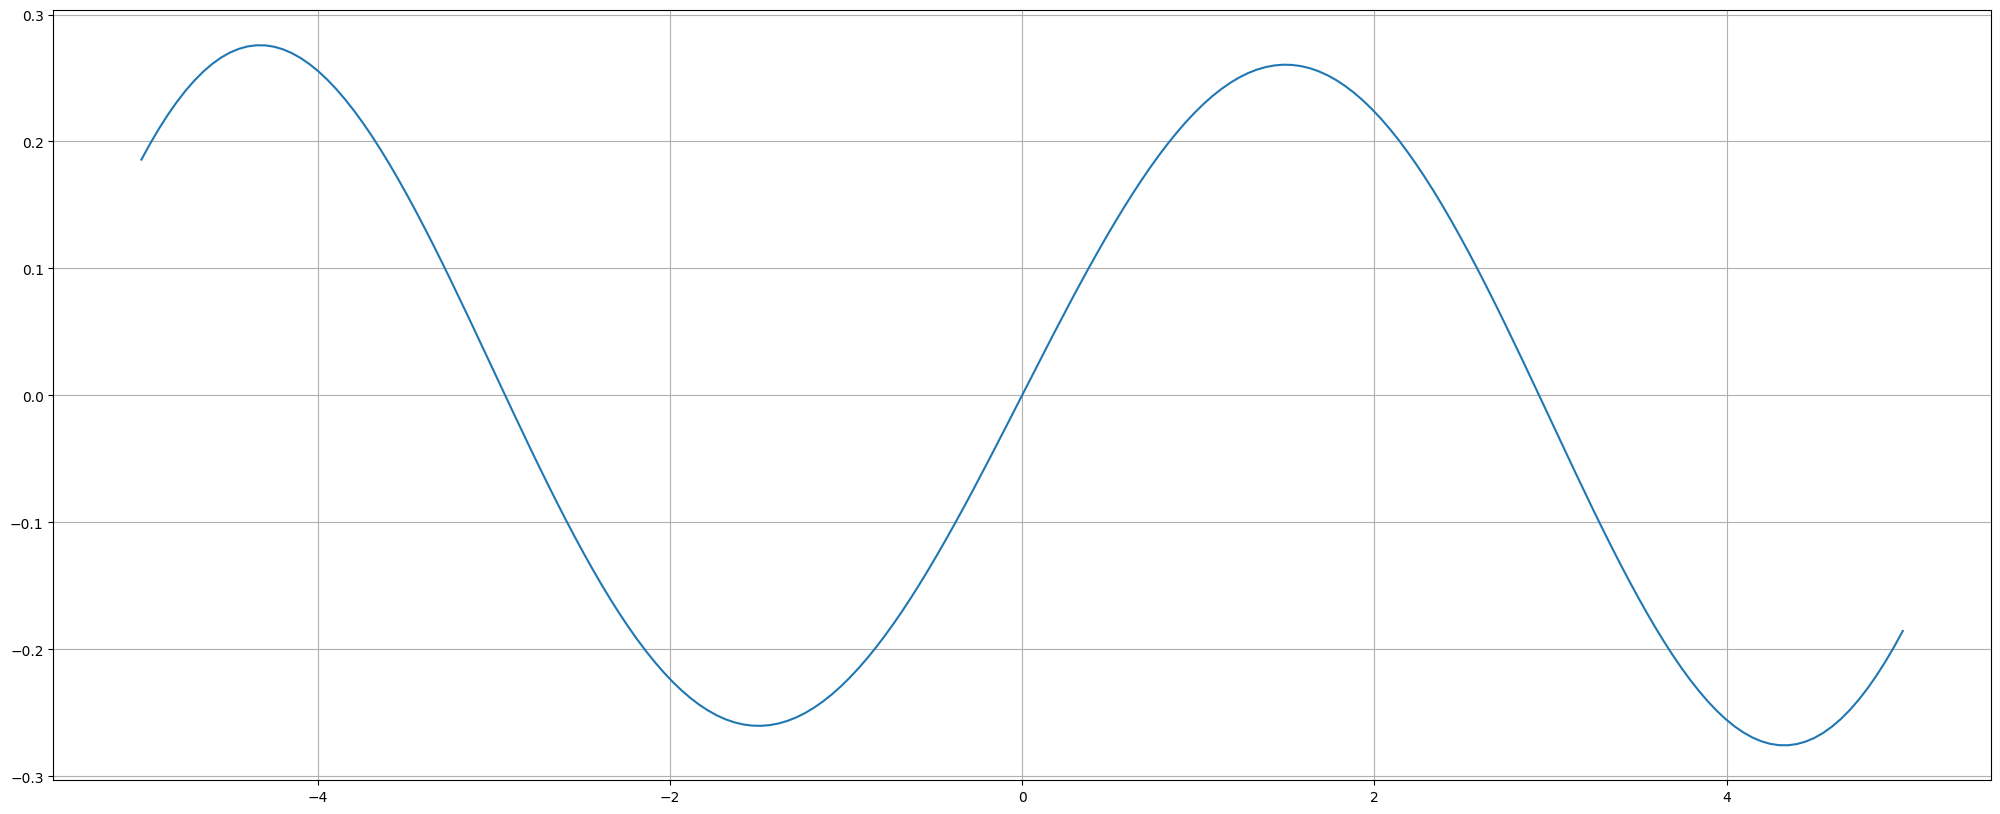

In [41]:
plt.figure(figsize=(25,10))
plt.plot(x, [f(g.scale_back([xi])) for xi in x])
plt.grid()

In [180]:
ip.weights

[array([-3.27200388e-06,  8.35071577e-05, -8.10065904e-07, -1.17259238e-05,
        -1.90126686e-06,  5.63938329e-05,  1.68488083e-06,  5.36552972e-06,
         2.35365374e-06, -1.31595794e-04])]

In [181]:
n = 100
X, Y = get_meshgrid(g, n)
xx = np.stack([X.ravel(), Y.ravel()], axis=1)
Z_f = np.array([f(xi) for xi in xx]).reshape(n, n)
Z_ip = ip(np.stack([X.ravel(), Y.ravel()], axis=1)).reshape(n, n)

fig, axes = plt.subplots(1, 3, figsize=(24, 5))
for ax, Z, title in zip(axes, [Z_f, Z_ip, Z_ip - Z_f], ['target', 'interpolant ', 'difference']):
    im = ax.imshow(Z, extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], origin='lower')
    ax.set_title(title); fig.colorbar(im, ax=ax)

plt.show()

ValueError: not enough values to unpack (expected 2, got 1)

In [7]:

ip = sj.MultivariateSmolyakBarycentricInterpolator(g=g, k=k, l=l, rank=1, f=f)
ipn = sn.MultivariateSmolyakBarycentricInterpolator(g=g, k=k, l=[l], f=f)

n = 100
X, Y = get_meshgrid(g, n)
xx = np.stack([X.ravel(), Y.ravel()], axis=1)
Z_f = np.array([f(xi) for xi in xx]).reshape(n, n)
Z_ip = ip(np.stack([X.ravel(), Y.ravel()], axis=1)).reshape(n, n)
Z_ipn = ipn(np.stack([X.ravel(), Y.ravel()], axis=1)).reshape(n, n)
Z_diff = Z_ipn - Z_ip

fig, axes = plt.subplots(1, 4, figsize=(24, 5))
for ax, Z, title in zip(axes, [Z_f, Z_ipn, Z_ip, Z_diff], ['target', 'interpolant numpy', 'interpolant jax', 'difference']):
    im = ax.imshow(Z, extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], origin='lower')
    ax.set_title(title); fig.colorbar(im, ax=ax)

plt.show()

NameError: name 'k' is not defined